<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/XgBoost_PJME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hourly Energy Consumption Prediction

https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [31]:
pjme = pd.read_csv('https://raw.githubusercontent.com/archd3sai/Hourly-Energy-Consumption-Prediction/master/PJME_hourly.csv', index_col = [0], parse_dates = [0])

In [32]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


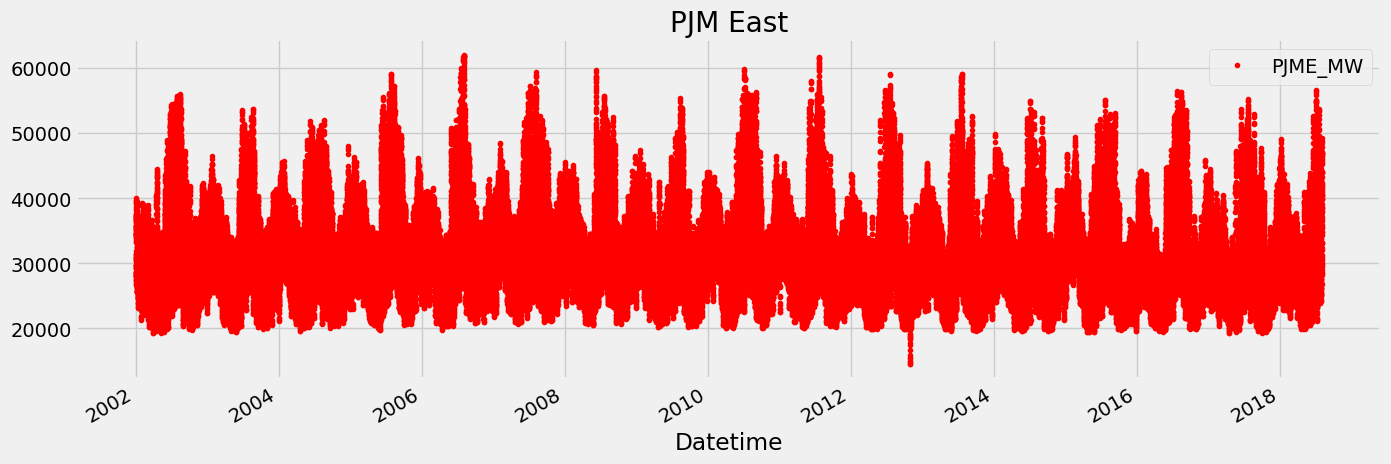

In [33]:
pjme.plot(style = '.' , color = "red", figsize = (15,5), title = "PJM East");

## EDA

Let's create time series features from datetime index

In [34]:
pjme['date'] = pjme.index
pjme['hour'] = pjme['date'].dt.hour
pjme['dayofweek'] = pjme['date'].dt.dayofweek
pjme['quarter'] = pjme['date'].dt.quarter
pjme['month'] = pjme['date'].dt.month
pjme['year'] = pjme['date'].dt.year
pjme['dayofyear'] = pjme['date'].dt.dayofyear
pjme['dayofmonth'] = pjme['date'].dt.day
pjme['weekofyear'] = pjme['date'].dt.weekofyear
pjme.drop(['date'], axis = 1, inplace=True)

<ipython-input-34-14c82bd8ae6e>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  pjme['weekofyear'] = pjme['date'].dt.weekofyear


In [35]:
pjme.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


In [36]:
pjme.isna().sum(axis = 0)

PJME_MW       0
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

<Axes: xlabel='hour', ylabel='PJME_MW'>

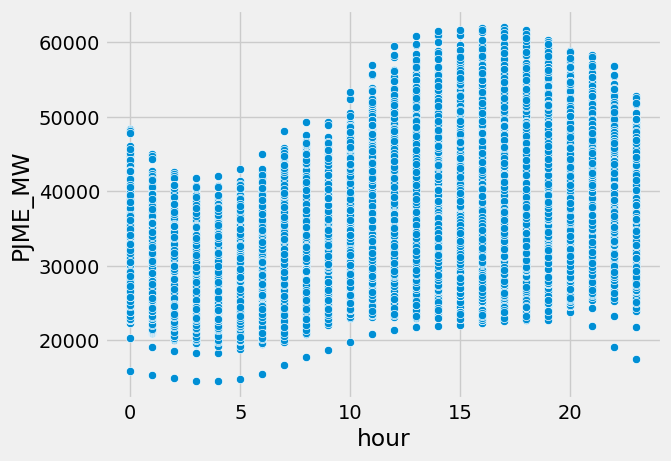

In [37]:
sns.scatterplot(x=pjme['hour'], y=pjme['PJME_MW'])

<Axes: xlabel='dayofweek', ylabel='PJME_MW'>

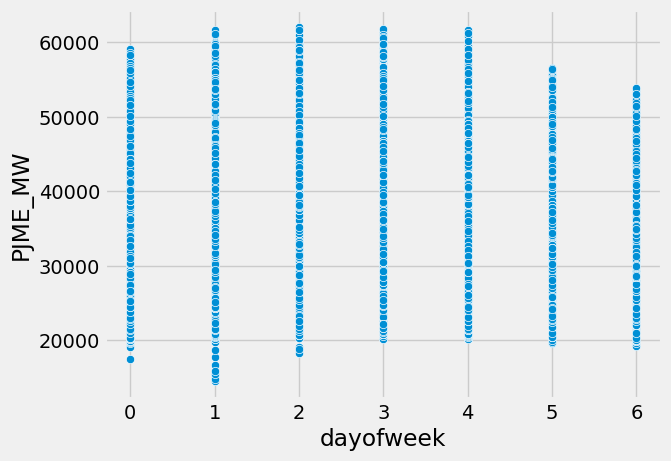

In [38]:
sns.scatterplot(x=pjme['dayofweek'], y=pjme['PJME_MW'] )

<Axes: xlabel='month', ylabel='PJME_MW'>

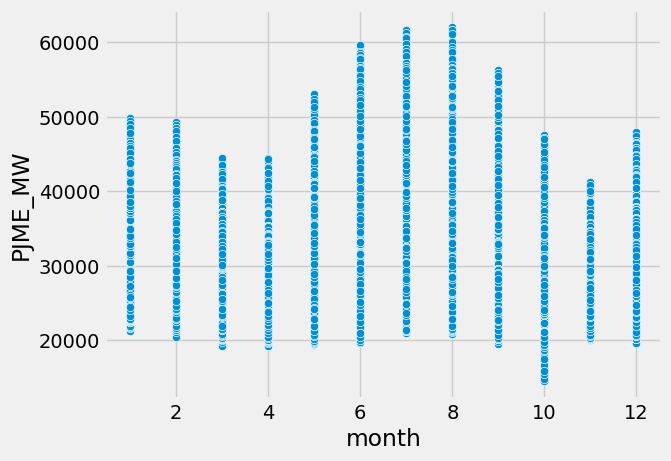

In [39]:
sns.scatterplot(x=pjme['month'], y=pjme['PJME_MW'])

(array([2000., 2002., 2004., 2006., 2008., 2010., 2012., 2014., 2016.,
        2018., 2020.]),
 [Text(2000.0, 0, '2000'),
  Text(2002.0, 0, '2002'),
  Text(2004.0, 0, '2004'),
  Text(2006.0, 0, '2006'),
  Text(2008.0, 0, '2008'),
  Text(2010.0, 0, '2010'),
  Text(2012.0, 0, '2012'),
  Text(2014.0, 0, '2014'),
  Text(2016.0, 0, '2016'),
  Text(2018.0, 0, '2018'),
  Text(2020.0, 0, '2020')])

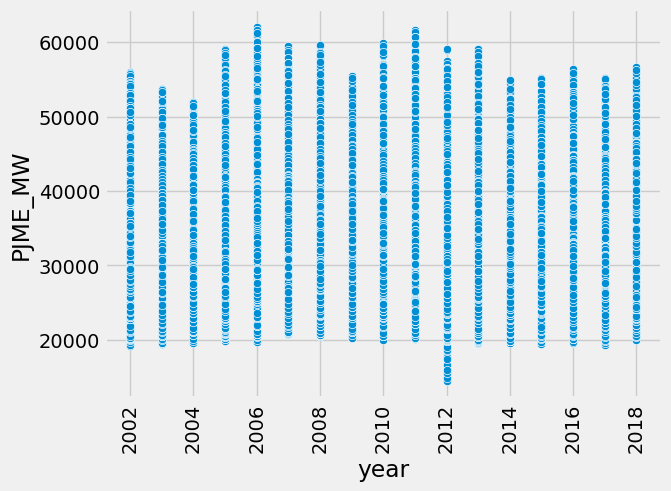

In [40]:
sns.scatterplot(x=pjme['year'], y=pjme['PJME_MW'])
plt.xticks(rotation = 'vertical')

<Axes: xlabel='weekofyear', ylabel='PJME_MW'>

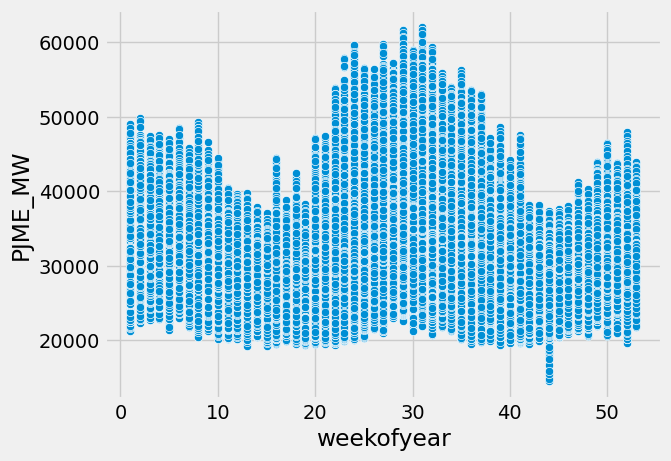

In [41]:
sns.scatterplot(x=pjme['weekofyear'], y=pjme['PJME_MW'])

## Train-Test Split

Cut off the data after 2015 to use as our validation set.

In [42]:
pjme_train = pjme.loc[pjme.year < 2015]
pjme_test = pjme.loc[pjme.year >= 2015]

In [43]:
pjme_train.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2014-01-01 20:00:00,36193.0,20,2,1,1,2014,1,1,1
2014-01-01 21:00:00,35601.0,21,2,1,1,2014,1,1,1
2014-01-01 22:00:00,34242.0,22,2,1,1,2014,1,1,1
2014-01-01 23:00:00,32215.0,23,2,1,1,2014,1,1,1
2014-01-02 00:00:00,30159.0,0,3,1,1,2014,2,2,1


In [44]:
pjme_test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,1,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,31,53


<ipython-input-45-61fce82c8951>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  (pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'})).append(pjme_test.rename(columns={'PJME_MW': 'TEST SET'}), sort = False)[['TRAINING SET','TEST SET']].plot(style='.', figsize = (15,5), title = "PJM East");


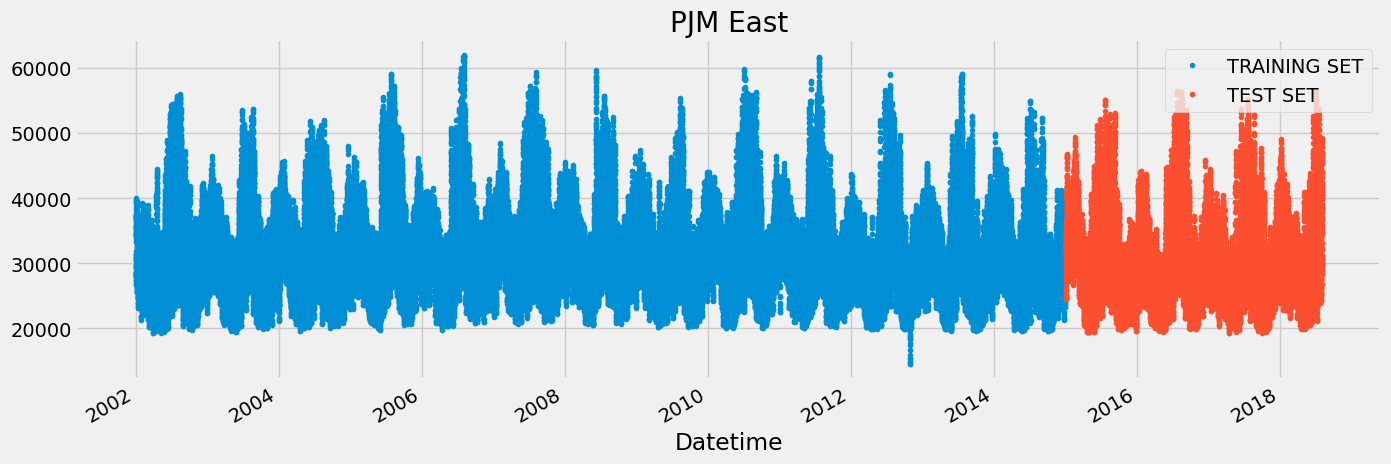

In [45]:
(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'})).append(pjme_test.rename(columns={'PJME_MW': 'TEST SET'}), sort = False)[['TRAINING SET','TEST SET']].plot(style='.', figsize = (15,5), title = "PJM East");

In [46]:
x_train = pjme_train[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
x_test = pjme_test[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
y_train = pjme_train[['PJME_MW']]
y_test = pjme_test[['PJME_MW']]

## XG Boost Model

In [47]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [48]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x_train, y_train,
       eval_set = [(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

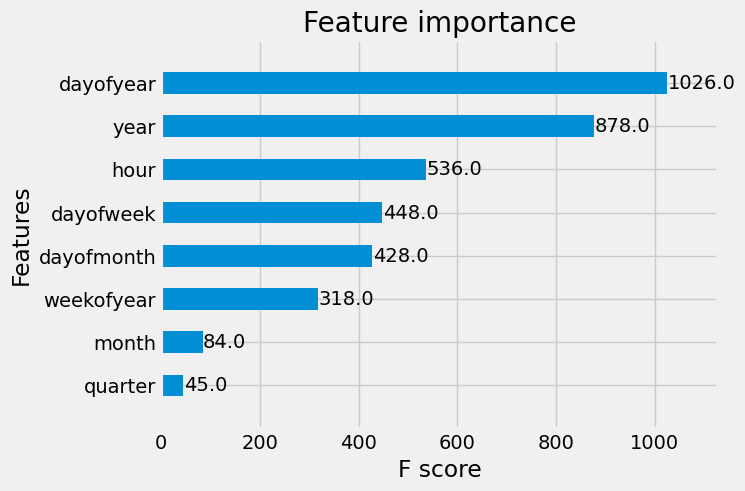

In [49]:
plot_importance(reg, height = 0.5)

In [50]:
pjme_test['MW_Prediction'] = reg.predict(x_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

<ipython-input-50-718a3d9e5890>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction'] = reg.predict(x_test)


<Axes: xlabel='Datetime'>

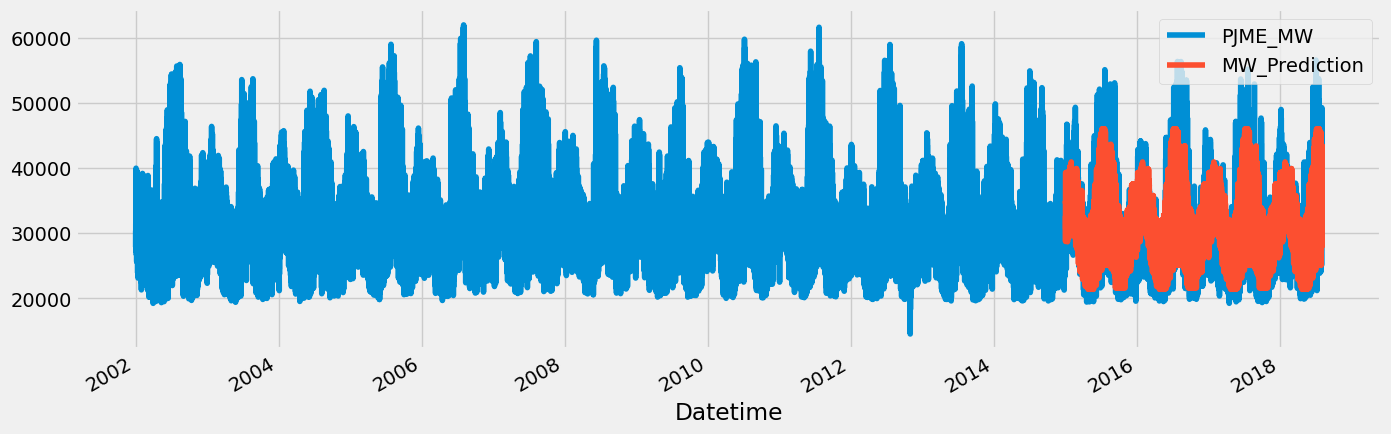

In [51]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

#### First Month of Prediction

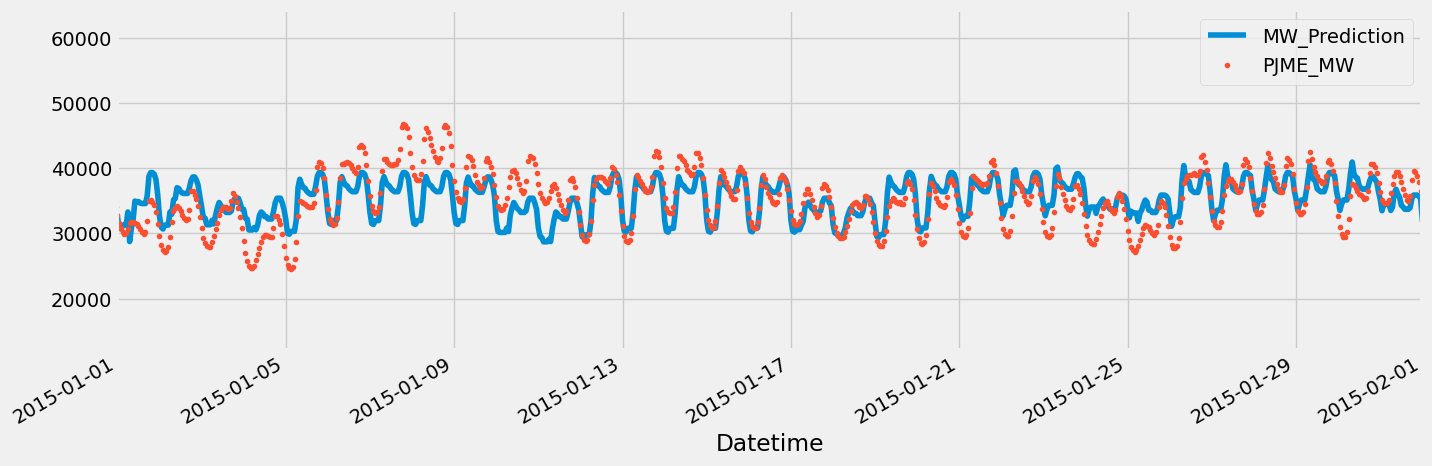

In [52]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')

#### First week of January

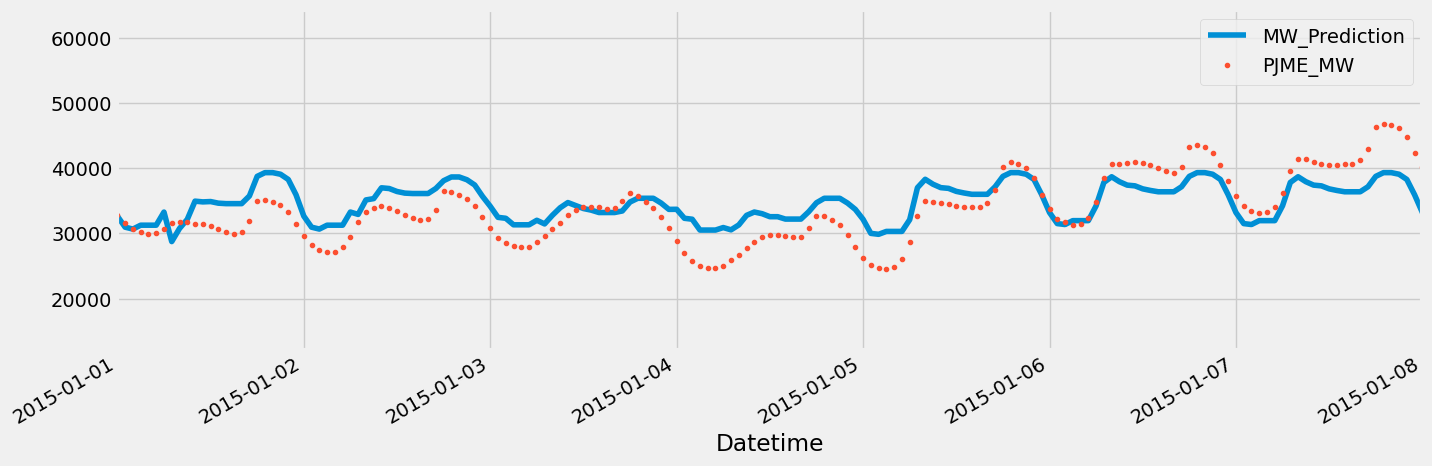

In [53]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')

#### First Week of July

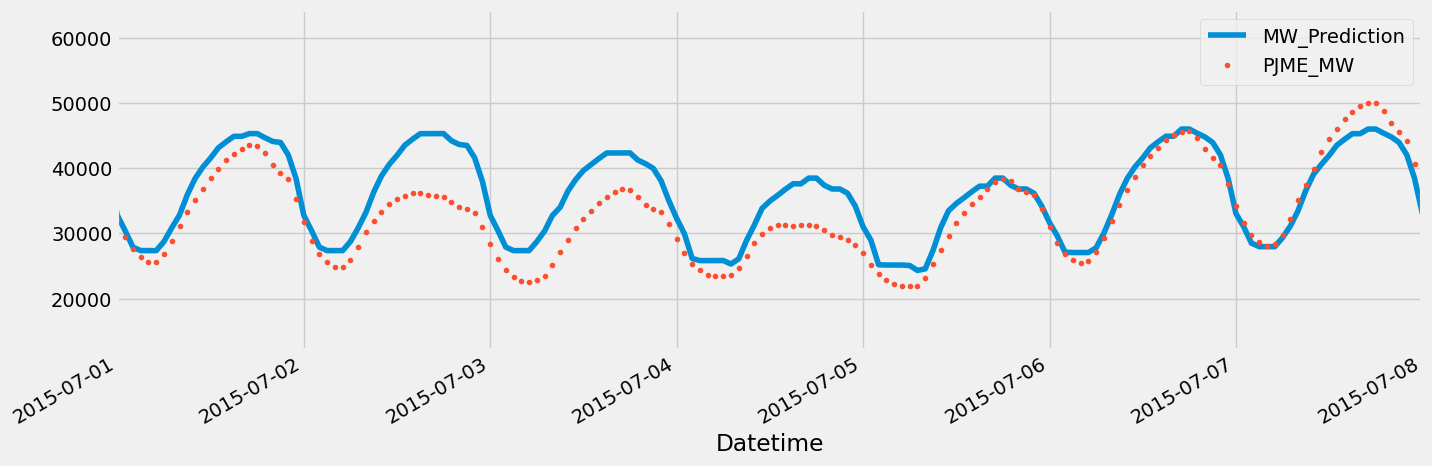

In [54]:
_, ax = plt.subplots(1)
pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax, style=['-','.'],figsize=(15, 5))
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')

#### Error Metrics

In [73]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

14054981.190890098

In [56]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2905.4618405718234

In [57]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

9.239080593498986

#### Analysis of worst and best predicted days

In [58]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)

<ipython-input-58-ef8a95843d13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
<ipython-input-58-ef8a95843d13>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)


In [59]:
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [60]:
error_by_day.head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 1     1           31765.583333   34279.917969 -2514.332438  2916.460205
           2           32141.166667   35147.710938 -3006.544108  3006.544108
           3           32014.375000   33421.964844 -1407.590332  1912.002767
           4           28542.291667   32752.591797 -4210.298584  4210.298584
           5           33176.125000   35443.953125 -2267.828695  2740.903564
           6           38358.833333   36087.574219  2271.258219  2364.630290
           7           40181.875000   36087.574219  4094.299886  4094.299886
           8           42445.375000   36087.574219  6357.799886  6357.799886
           9           38524.666667   35883.230469  2641.437093  2641.437093
           10          37703.583333   32902.105469  4801.476562  4801.476562

##### Over feorecasted days

In [61]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   37517.808594 -9117.849284  9117.849284
2017 2     24          26445.083333   34674.429688 -8229.345540  8229.345540
           25          24344.458333   32168.226562 -7823.768962  7823.768962
           20          27070.583333   34740.058594 -7669.474854  7669.474854
           23          27663.416667   35190.175781 -7526.756836  7526.756836
           19          24555.500000   32075.982422 -7520.482096  7520.482096
2018 2     21          27572.500000   35071.824219 -7499.323405  7499.323405
2017 2     28          28297.875000   35778.199219 -7480.322103  7480.322103
2015 12    25          24466.083333   31934.220703 -7468.137858  7468.137858
2017 5     29          24528.416667   31898.541016 -7370.126139  7370.126139

We can see,
1st worst day: 4th July,2016 - Holiday
3rd worst day: 25th December,2015 - Christmas
5th worst day: 4th July,2016 - Holiday

We should consider holidays in our analysis.

##### Worst Absolute Predicted days

In [62]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31933.898438  13251.935059  13251.935059
           14          44427.333333   31571.759766  12855.574137  12855.574137
     9     10          40996.166667   29231.992188  11764.174886  11764.174886
           9           43836.958333   32909.203125  10927.755615  10927.755615
2018 1     6           43565.750000   33296.144531  10269.602865  10269.602865
2016 8     12          45724.708333   35532.183594  10192.522380  10192.522380
2015 2     20          44694.041667   34556.078125  10137.962891  10137.962891
2018 1     7           42159.708333   32626.771484   9532.936442   9532.936442
2017 5     19          38032.583333   28695.591797   9336.993327   9336.993327
2015 2     16          43949.500000   34775.167969   9174.330322   9174.330322

##### Best Absolute Predicted days

In [63]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 12    30          32213.458333   32181.312500   32.145833  293.818197
     10    27          28611.166667   28468.580078  142.585775  395.877116
2017 10    24          28657.416667   28500.568359  156.848470  418.393555
2015 10    28          28500.958333   28500.568359    0.390137  437.237956
     5     6           28948.666667   28924.150391   24.515299  467.244466
2016 8     8           36256.041667   36075.074219  180.966960  565.314941
2017 9     14          32033.875000   31962.013672   71.862305  596.356120
     5     2           28546.916667   28924.150391 -377.234701  596.780924
     8     12          31822.666667   32056.861328 -234.194499  597.044108
2016 12    12          32757.208333   33159.652344 -402.443929  597.560954

The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may.

#### Plotting Best/Worst predicted Days

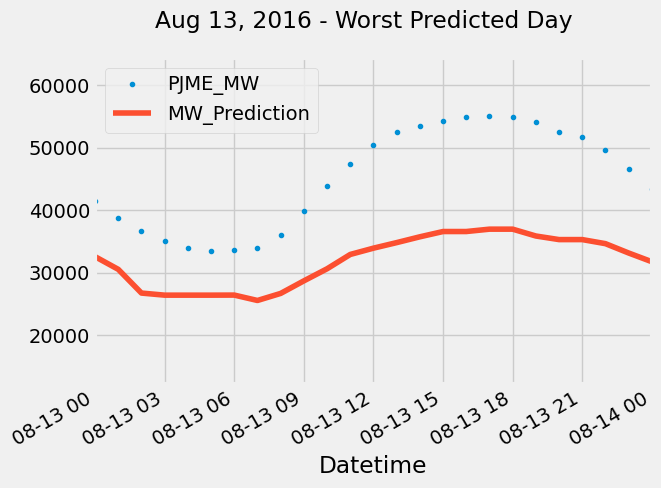

In [64]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

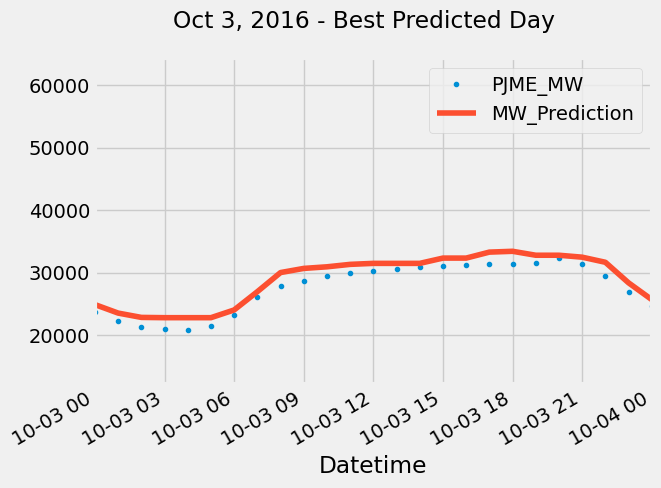

In [65]:
_, ax = plt.subplots(1)
pjme_all[['PJME_MW','MW_Prediction']].plot(ax=ax, style=['.','-'])
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

## Linear model

In [66]:
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, HuberRegressor
reg=LinearRegression(fit_intercept=False)
reg.fit(x_train, y_train)

LinearRegression(fit_intercept=False)

In [67]:
reg.coef_

array([[ 4.62331140e+02, -6.15994955e+02, -2.46449932e+02,
        -8.72852839e+03,  1.90911294e+01,  2.86767207e+02,
        -2.84673613e+02,  1.99219116e-01]])

In [68]:
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_lin'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_lin'])

0.20498011763741297


<ipython-input-68-9645a8731533>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_lin'] = reg.predict(x_test)


15.52594823100164

In [69]:
from sklearn.neighbors import KNeighborsRegressor
#https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression
reg = KNeighborsRegressor(n_neighbors=4)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_knn'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_knn'])

0.43800296698928287


<ipython-input-69-479a324c830b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_knn'] = reg.predict(x_test)


11.468180182880443

In [70]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(max_depth=50, random_state=0)
reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_rfr'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_rfr'])

<ipython-input-70-20812fefef2b>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(x_train, y_train)


0.5564512284355667


<ipython-input-70-20812fefef2b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_rfr'] = reg.predict(x_test)


9.834870999124446

In [71]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor


# Training Regressors
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(max_depth=50, random_state=1)
reg3 = KNeighborsRegressor(n_neighbors=3)
reg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg = reg.fit(x_train, y_train)
y_pred=reg.predict(x_test)
pjme_test['MW_Prediction_Grad'] = reg.predict(x_test)
from sklearn.metrics import r2_score
rez=r2_score(y_test, y_pred)
print(rez)
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction_Grad'])

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6165275876714758


<ipython-input-71-e96197f5ea42>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_test['MW_Prediction_Grad'] = reg.predict(x_test)


9.43474424978312

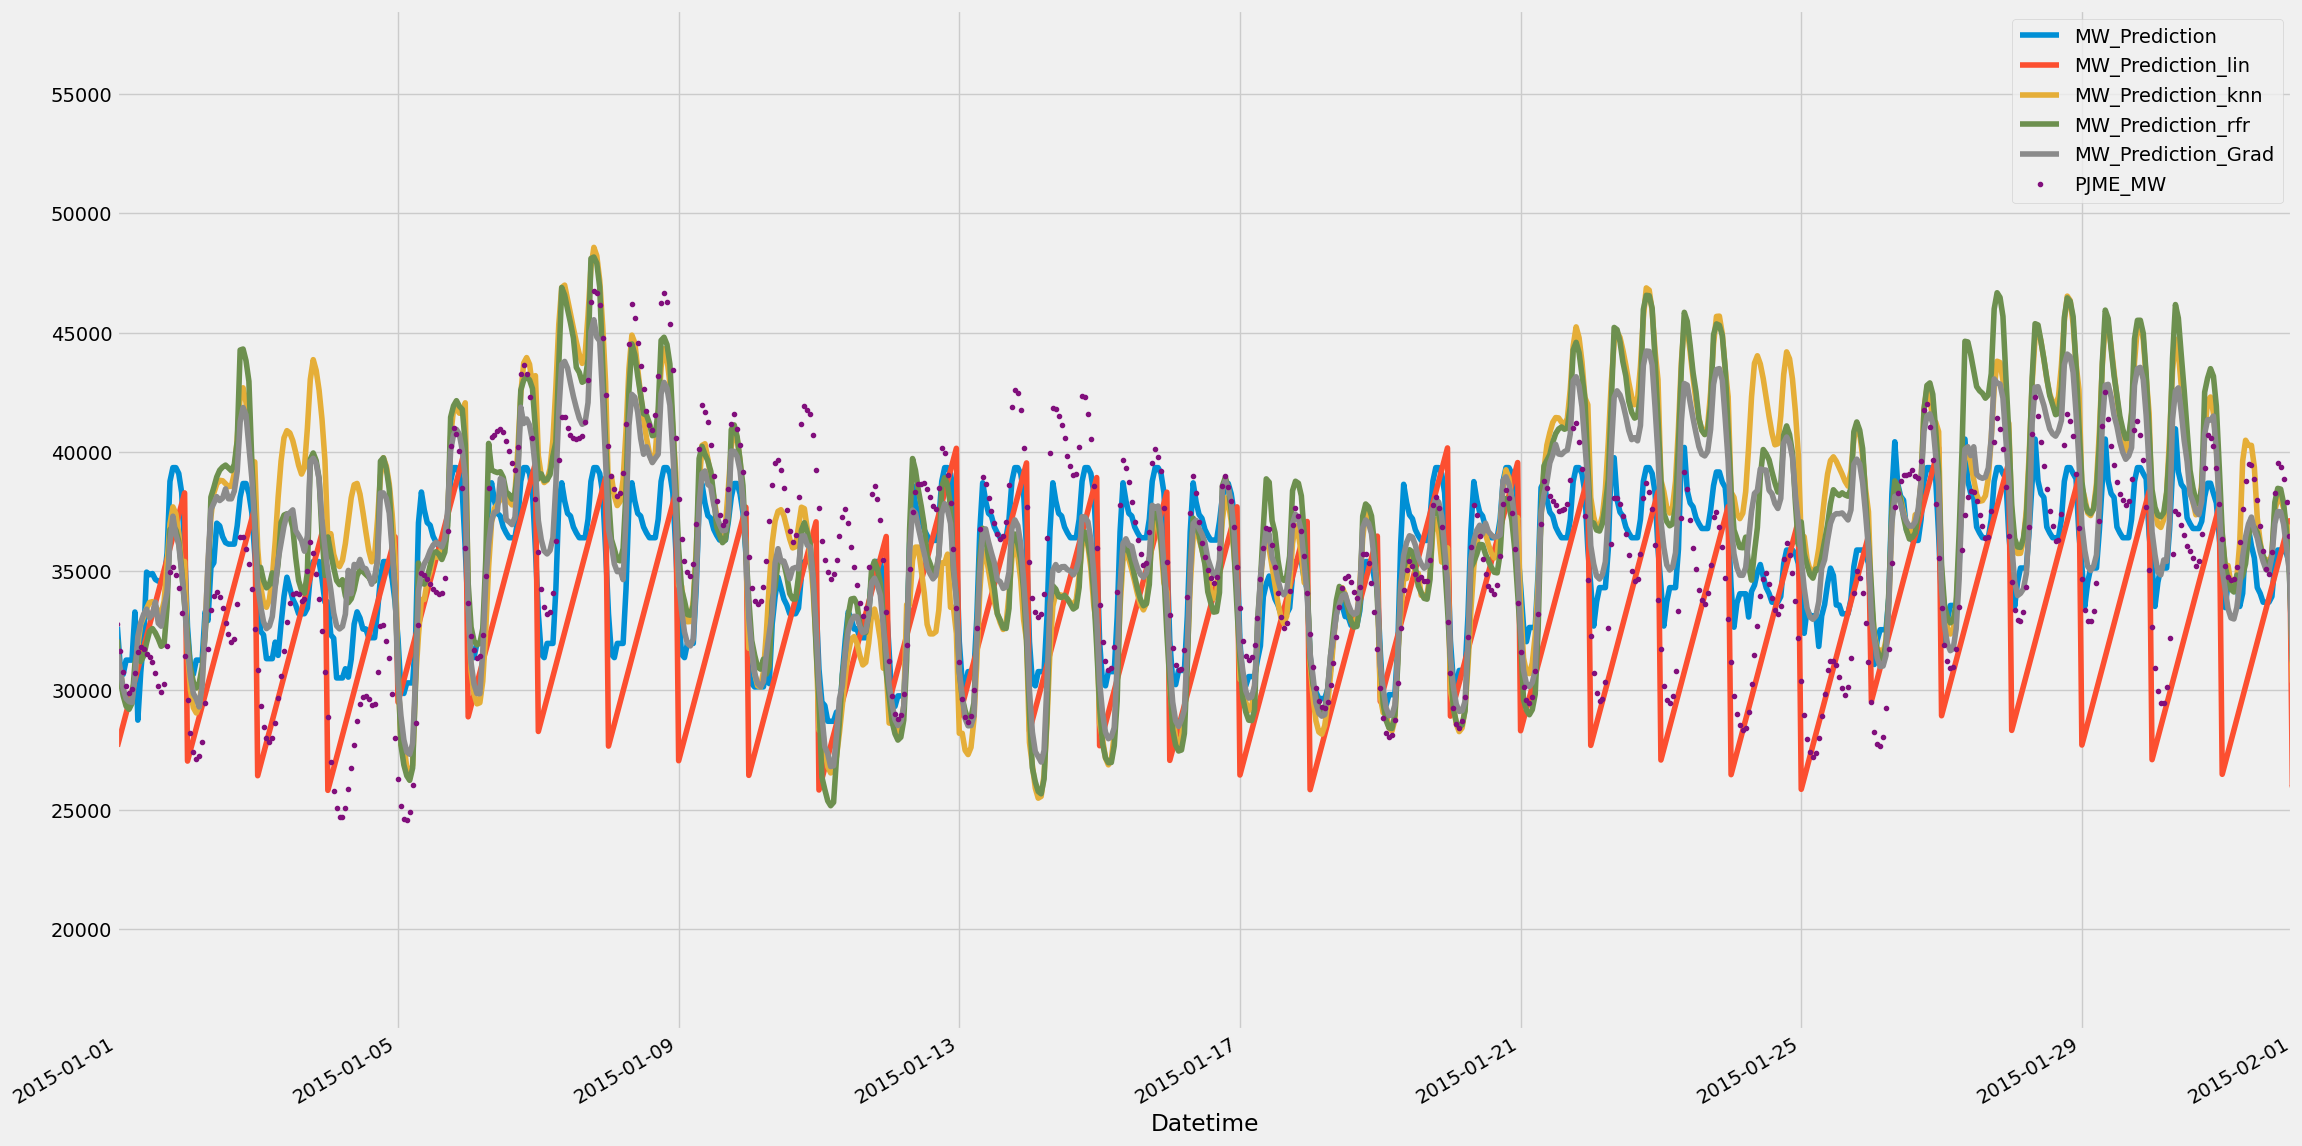

In [72]:
_, ax = plt.subplots(1)
pjme_test[['MW_Prediction', 'MW_Prediction_lin','MW_Prediction_knn','MW_Prediction_rfr','MW_Prediction_Grad','PJME_MW']].plot(ax=ax, style=['-','-','-','-','-','.'],figsize=(25, 15))
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')

In [74]:
x_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...
2014-01-01 20:00:00,20,2,1,1,2014,1,1,1
2014-01-01 21:00:00,21,2,1,1,2014,1,1,1
2014-01-01 22:00:00,22,2,1,1,2014,1,1,1
